In [1]:
import cv2
import torch
from torch import nn
import numpy as np
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [2]:
class ImprovedAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, 11, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            
            nn.Conv2d(96, 256, 5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            
            nn.Conv2d(256, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, 3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            
            nn.AdaptiveAvgPool2d((6, 6))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512*6*6, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Linear(4096, 15),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 512*6*6)
        return self.classifier(x)

In [3]:
def load_detection_model(model_type='yolo'):
    """Загрузка модели детекции"""
    if model_type == 'yolo':
        model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
    elif model_type == 'detr':
        from transformers import DetrImageProcessor, DetrForObjectDetection
        processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
        model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
        return model, processor
    return model, None

# Детекция
def detect_parrot(image, model_type='yolo'):
    """Детекция попугая на изображении"""
    try:
        if model_type == 'yolo':
            model, _ = load_detection_model(model_type)
            results = model([image])
            detections = results.pandas().xyxy[0]
            parrot_boxes = detections[detections['name'] == 'bird']
            if len(parrot_boxes) == 0:
                return None, "Parrot not detected"
            bbox = parrot_boxes.iloc[0][['xmin', 'ymin', 'xmax', 'ymax']].values.astype(int)
            return bbox.tolist(), 'yolo'
        
        elif model_type == 'detr':
            model, processor = load_detection_model(model_type)
            inputs = processor(images=image, return_tensors="pt")
            outputs = model(**inputs)
            target_sizes = torch.tensor([image.size[::-1]])
            results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.7)[0]
            bird_indices = [i for i, label in enumerate(results["labels"]) if label == 16]
            if not bird_indices:
                return None, "Parrot not detected"
            bbox = results["boxes"][bird_indices[0]].int().tolist()
            return bbox, 'detr'
    
    except Exception as e:
        raise RuntimeError(f"Detection error: {str(e)}")

# Обрезка
def crop_image(image, bbox):
    """Обрезка изображения по bounding box"""
    return image.crop(bbox)


class CustomResizeTransform:
    def __init__(self, target_size):
        self.target_size = target_size
    
    def __call__(self, img):
        # Получаем размеры исходного изображения
        width, height = img.size
        
        # Если обе стороны меньше или равны целевому размеру - просто растягиваем
        if width <= self.target_size and height <= self.target_size:
            return img.resize((self.target_size, self.target_size), Image.BILINEAR)
        
        # Если одна из сторон больше - сжимаем до target_size с сохранением пропорций
        else:
            if width > height:
                new_width = self.target_size
                new_height = int(height * (self.target_size / width))
            else:
                new_height = self.target_size
                new_width = int(width * (self.target_size / height))
            
            # Делаем resize до новых размеров
            img = img.resize((new_width, new_height), Image.BILINEAR)
            
            # Если после resize одна из сторон меньше target_size - добавляем padding
            if img.size[0] < self.target_size or img.size[1] < self.target_size:
                new_img = Image.new(img.mode, (self.target_size, self.target_size))
                new_img.paste(img, ((self.target_size - img.size[0]) // 2, 
                                   (self.target_size - img.size[1]) // 2))
                return new_img
            else:
                return img
    
# Классификация
class ParrotClassifier:
    def __init__(self, model_path='models/ImprovedAlexNet_YOLO_6.pth'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.model = ImprovedAlexNet()
        
        state_dict = torch.load(model_path, map_location=self.device)
        self.model.load_state_dict(state_dict)
        
        self.model.to(self.device)
        self.model.eval()
        
        self.transform = transforms.Compose([
            CustomResizeTransform(224), 
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        self.classes = ["Большой Желтохохлый Какаду",
               "Буроухий Краснохвостый Попугай",
               "Волнистый Попугайчик",
               "Зеленокрылый Ара",
               "Индийский кольчатый попугай",
               "Корелла",
               "Королевский Попугай",
               "Красная Розелла",
               "Краснохвостый Траурный Какаду",
               "Красный Ара",
               "Розовощёкий Неразлучник",
               "Розовый Какаду",
               "Сине-жёлтый Ара",
               "Украшенный Лорикет",
               "Черноголовый Попугай"]

    def predict(self, image, visualize=False):
        """Предсказание класса с возможностью визуализации"""
        # Apply transformations
        tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, pred = torch.max(outputs, 1)
            
        class_name = self.classes[pred.item()]
        class_probs = {self.classes[i]: float(probabilities[0][i]) for i in range(len(self.classes))}
        
        if visualize:
            self.visualize_prediction(image, class_name, class_probs)
            
        return class_name, class_probs
    
    def visualize_prediction(self, image, class_name, class_probs):
        """Визуализация изображения и предсказания"""
        plt.figure(figsize=(15, 5))
        
        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis('off')
        
        # Transformed image (as seen by model)
        transformed_img = self.transform(image)
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img - transformed_img.min()) / (transformed_img.max() - transformed_img.min())
        
        plt.subplot(1, 3, 2)
        plt.imshow(transformed_img)
        plt.title("Transformed Image (model input)")
        plt.axis('off')
        
        # Probabilities
        plt.subplot(1, 3, 3)
        colors = plt.cm.viridis(np.linspace(0, 1, len(class_probs)))
        plt.barh(list(class_probs.keys()), list(class_probs.values()), color=colors)
        plt.title(f"Prediction Probabilities\nPredicted: {class_name}")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.show()



In [ ]:
def parrot_pipeline(image_path, detection_model='yolo', classifier_model='results/models/ImprovedAlexNet_YOLO_6.pth', visualize=True, true_class=None):
    """Полный пайплайн распознавания попугаев с улучшенной визуализацией"""
    
    try:
        # 1. Загрузка изображения
        image = Image.open(image_path).convert('RGB')
        
        # 2. Детекция
        bbox, detector_type = detect_parrot(image, detection_model)
        if bbox is None:
            bbox = [34, 410, 921, 1245]
        
        cropped_image = crop_image(image, bbox)
        
        # 4. Классификация
        classifier = ParrotClassifier(classifier_model)
        result, probs = classifier.predict(cropped_image, visualize=False)
        
        # 5. Подготовка изображения для модели
        transformed_img = classifier.transform(cropped_image)
        model_input_img = transformed_img.permute(1, 2, 0).numpy()
        model_input_img = (model_input_img - model_input_img.min()) / (model_input_img.max() - model_input_img.min())
        
        # Визуализация
        if visualize:
            fig = plt.figure(figsize=(18, 12))
            
            # Добавляем общий заголовок
            if true_class is not None:
                if result == true_class:
                    title_text = f"ВЕРНО! Предсказанный класс: {result} (Истинный класс: {true_class})"
                    title_color = 'green'
                else:
                    title_text = f"ОШИБКА! Предсказанный класс: {result} (Истинный класс: {true_class})"
                    title_color = 'red'
            else:
                title_text = f"Классификация видов попугаев с помощью Сверточной нейронной сети\n Результат классификации: {result} (Детектор: {detector_type.upper()})"
                title_color = 'black'
            
            fig.suptitle(title_text, fontsize=20, color=title_color, y=0.99)
            
            # Первый ряд - изображения (4 колонки)
            plt.subplot(2, 4, 1)
            plt.imshow(image)
            plt.title("1. Исходное изображение", fontsize=12)
            plt.axis('off')
            
            # Изображение с детекцией
            detected_image = image.copy()
            draw = ImageDraw.Draw(detected_image)
            draw.rectangle(bbox, outline="red", width=3)
            
            plt.subplot(2, 4, 2)
            plt.imshow(detected_image)
            plt.title(f"2. Детекция ({detector_type.upper()})", fontsize=12)
            plt.axis('off')
            
            plt.subplot(2, 4, 3)
            plt.imshow(cropped_image)
            plt.title("3. Обрезанный попугай", fontsize=12)
            plt.axis('off')
            
            plt.subplot(2, 4, 4)
            plt.imshow(model_input_img)
            plt.title("4. Преобразованное для модели", fontsize=12)
            plt.axis('off')
            
            # Второй ряд - график вероятностей (занимает все 4 колонки)
            plt.subplot(2, 1, 2)
            
            # Определяем цвета для классов
            colors = []
            for class_name in probs.keys():
                if true_class is not None and class_name == true_class:
                    colors.append('green')
                elif true_class is not None and class_name == result:
                    colors.append('red')
                else:
                    colors.append('gray')

            bars = plt.bar(list(probs.keys()), list(probs.values()), color=colors)
            plt.title("Распределение вероятностей по классам")
            plt.ylabel('Вероятность', fontsize=12)  # Изменили на plt.ylabel для вертикального графика
            plt.ylim(0, 1)  # Изменили на plt.ylim
            plt.grid(axis='y', linestyle='--', alpha=0.7)  # Изменили на axis='y'

            # Добавляем значения вероятностей на бары (вертикальная версия)
            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
                        f'{height:.3f}', 
                        ha='center', va='bottom', fontsize=10)

            # Поворачиваем подписи классов для лучшей читаемости
            plt.xticks(rotation=45, ha='right')
            
            plt.tight_layout()
            plt.show()
        
        # Подготовка выходных данных
        output = {
            "detection": {
                "bbox": bbox,
                "detector": detector_type
            },
            "classification": {
                "class": result,
                "probabilities": probs,
                "is_correct": true_class is not None and result == true_class,
                "true_class": true_class
            },
            "visualization": {
                "title": title_text if visualize else None,
                "title_color": title_color if visualize else None
            }
        }
        
        print(f"Result: {result}")
        if true_class is not None:
            print(f"True class: {true_class}")
            print(f"Prediction is {'CORRECT' if result == true_class else 'INCORRECT'}")
        print("Probabilities:", probs)
        
        return output
    
    except Exception as e:
        raise RuntimeError(f"Pipeline error: {str(e)}")

Using cache found in C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-4-21 Python-3.13.1 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 2060 SUPER, 8192MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
C:\Users\user/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


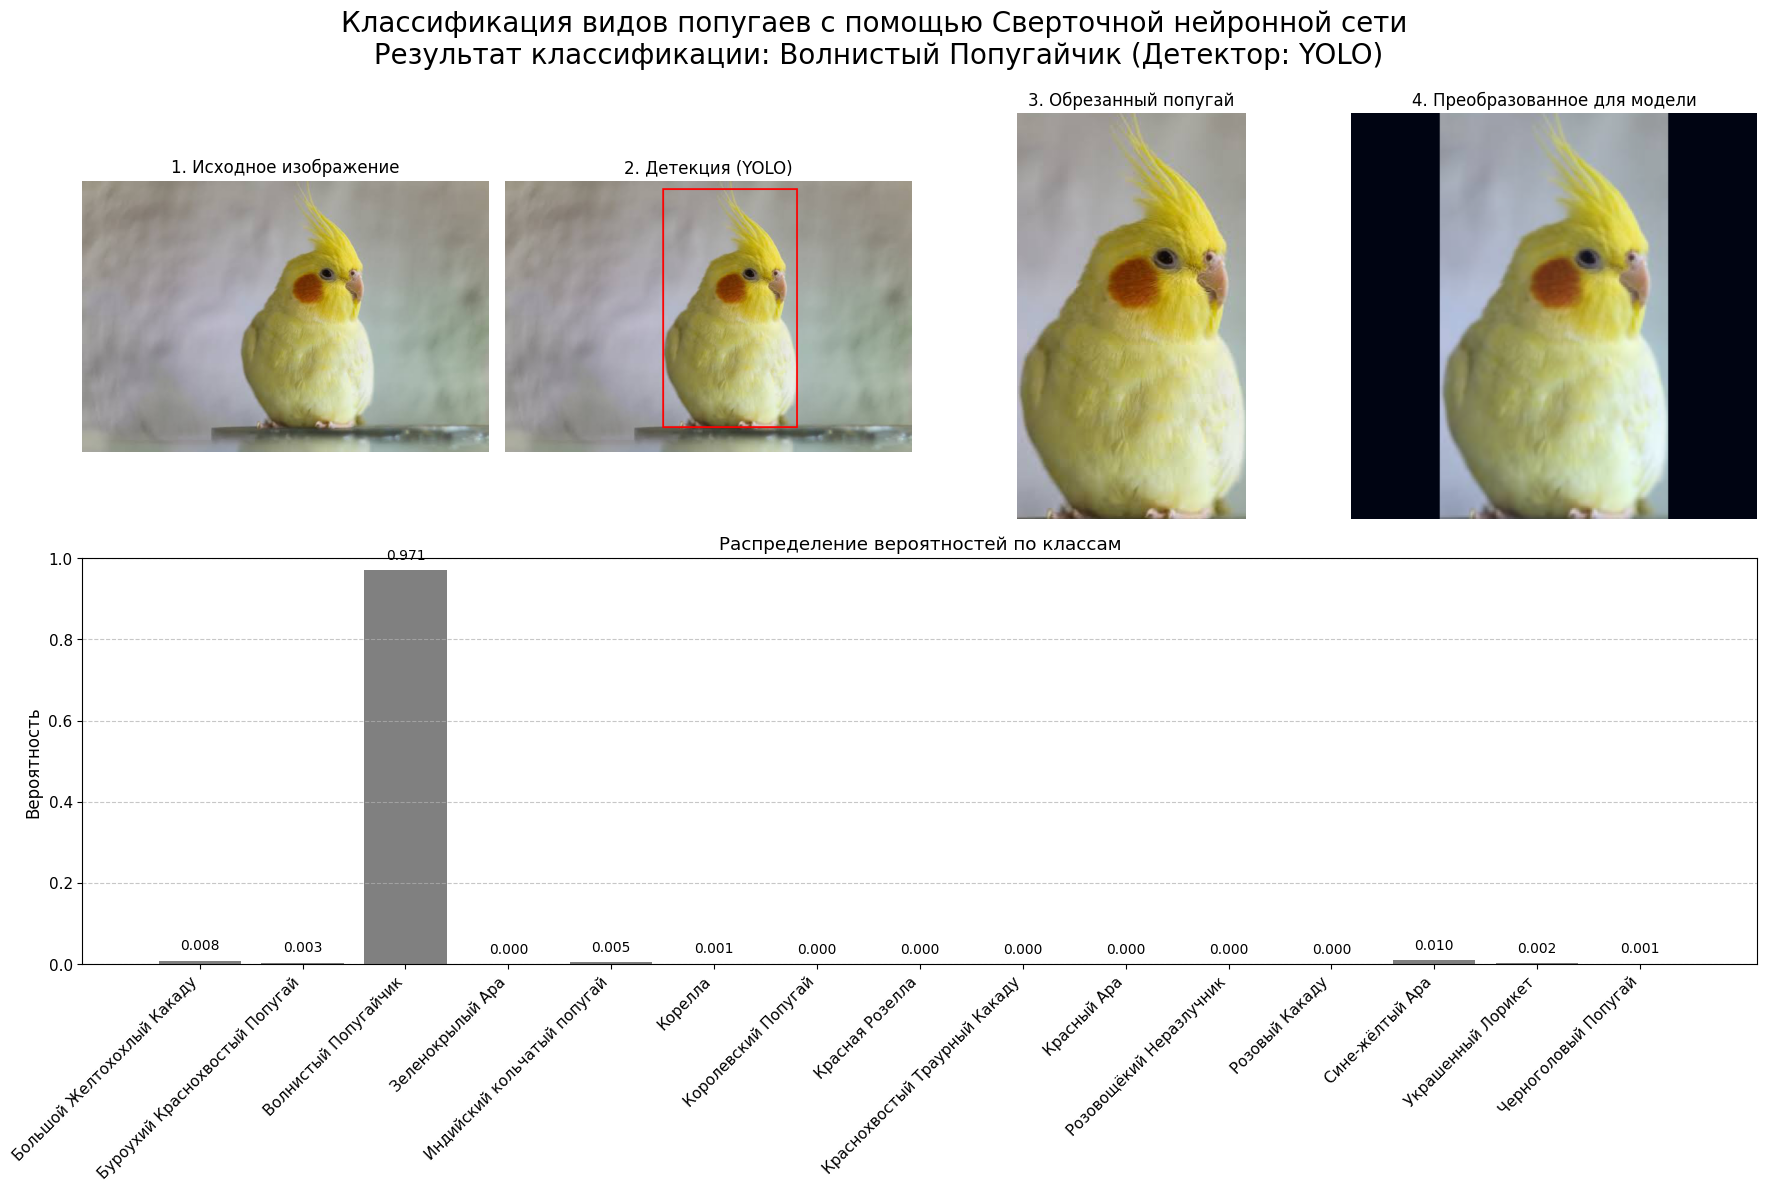

Result: Волнистый Попугайчик
Probabilities: {'Большой Желтохохлый Какаду': 0.007774785161018372, 'Буроухий Краснохвостый Попугай': 0.0033004397992044687, 'Волнистый Попугайчик': 0.9707329273223877, 'Зеленокрылый Ара': 4.2108777620342153e-07, 'Индийский кольчатый попугай': 0.005015677772462368, 'Корелла': 0.0005222805775702, 'Королевский Попугай': 1.0193750767939491e-06, 'Красная Розелла': 4.83832300233189e-05, 'Краснохвостый Траурный Какаду': 1.6801152014522813e-05, 'Красный Ара': 7.712316437391564e-05, 'Розовощёкий Неразлучник': 9.8335594884702e-06, 'Розовый Какаду': 1.4204863418854075e-07, 'Сине-жёлтый Ара': 0.009852658025920391, 'Украшенный Лорикет': 0.0017670858651399612, 'Черноголовый Попугай': 0.000880423525813967}


{'detection': {'bbox': [262, 12, 487, 411], 'detector': 'yolo'},
 'classification': {'class': 'Волнистый Попугайчик',
  'probabilities': {'Большой Желтохохлый Какаду': 0.007774785161018372,
   'Буроухий Краснохвостый Попугай': 0.0033004397992044687,
   'Волнистый Попугайчик': 0.9707329273223877,
   'Зеленокрылый Ара': 4.2108777620342153e-07,
   'Индийский кольчатый попугай': 0.005015677772462368,
   'Корелла': 0.0005222805775702,
   'Королевский Попугай': 1.0193750767939491e-06,
   'Красная Розелла': 4.83832300233189e-05,
   'Краснохвостый Траурный Какаду': 1.6801152014522813e-05,
   'Красный Ара': 7.712316437391564e-05,
   'Розовощёкий Неразлучник': 9.8335594884702e-06,
   'Розовый Какаду': 1.4204863418854075e-07,
   'Сине-жёлтый Ара': 0.009852658025920391,
   'Украшенный Лорикет': 0.0017670858651399612,
   'Черноголовый Попугай': 0.000880423525813967},
  'is_correct': False,
  'true_class': None},
 'visualization': {'title': 'Классификация видов попугаев с помощью Сверточной нейронно

In [24]:
%matplotlib inline
parrot_pipeline("test\\images.png", "yolo", 'results/models/ImprovedAlexNet_YOLO.pth')